# Linear regression

In [1]:
using DynamicHMCModels, MCMCChains

ProjDir = rel_path_d("..", "scripts", "05")
cd(ProjDir)

Import the dataset.

### snippet 5.1

In [2]:
wd = CSV.read(rel_path("..", "data", "WaffleDivorce.csv"), delim=';')
df = convert(DataFrame, wd);
mean_ma = mean(df[!, :MedianAgeMarriage])
df[!, :MedianAgeMarriage_s] = convert(Vector{Float64},
  (df[!, :MedianAgeMarriage]) .- mean_ma)/std(df[!, :MedianAgeMarriage]);

Show the first six rows of the dataset.

In [3]:
first(df, 6)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce
,String,String,Float64,Float64,Float64,Float64,Float64
1,Alabama,AL,4.78,25.3,20.2,1.27,12.7
2,Alaska,AK,0.71,25.2,26.0,2.93,12.5
3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8
4,Arkansas,AR,2.92,24.3,26.4,1.7,13.5
5,California,CA,37.25,26.8,19.1,0.39,8.0
6,Colorado,CO,5.03,25.7,23.5,1.24,11.6


Model ``y ∼ Normal(y - Xβ, σ)``. Flat prior for `β`, half-T for `σ`.

In [4]:
struct WaffleDivorceProblem{TY <: AbstractVector, TX <: AbstractMatrix}
    "Observations."
    y::TY
    "Covariates"
    X::TX
end

Make the type callable with the parameters *as a single argument*.

In [5]:
function (problem::WaffleDivorceProblem)(θ)
    @unpack y, X, = problem   # extract the data
    @unpack β, σ = θ            # works on the named tuple too
    ll = 0.0
    ll += logpdf(Normal(10, 10), X[1]) # a = X[1]
    ll += logpdf(Normal(0, 1), X[2]) # b1 = X[2]
    ll += logpdf(TDist(1.0), σ)
    ll += loglikelihood(Normal(0, σ), y .- X*β)
    ll
end

Instantiate the model with data and inits.

In [6]:
N = size(df, 1)
X = hcat(ones(N), df[!, :MedianAgeMarriage_s]);
y = convert(Vector{Float64}, df[!, :Divorce])
p = WaffleDivorceProblem(y, X);
p((β = [1.0, 2.0], σ = 1.0))

-2225.6614871340917

Write a function to return properly dimensioned transformation.

In [7]:
problem_transformation(p::WaffleDivorceProblem) =
    as((β = as(Array, size(p.X, 2)), σ = asℝ₊))

problem_transformation (generic function with 1 method)

Wrap the problem with a transformation, then use Flux for the gradient.

In [8]:
P = TransformedLogDensity(problem_transformation(p), p)
∇P = ADgradient(:ForwardDiff, P);

Create an array to hold 1000 samples of 3 parameters in 4 chains

In [9]:
a3d = create_a3d(1000, 3, 4);
trans = as( (β = as(Array, 2), σ = asℝ));

Sample from 4 chains and store the draws in the a3d array

In [10]:
for j in 1:4
  chain, NUTS_tuned = NUTS_init_tune_mcmc(∇P, 3000);
  posterior = TransformVariables.transform.(Ref(problem_transformation(p)),
    get_position.(chain));
  insert_chain!(a3d, j, posterior, trans);
end;

cnames = ["a", "bA", "sigma"]
chns = Chains(a3d, cnames)

MCMC, adapting ϵ (75 steps)
9.7e-5 s/step ...done
MCMC, adapting ϵ (25 steps)
0.00085 s/step ...done
MCMC, adapting ϵ (50 steps)
9.1e-5 s/step ...done
MCMC, adapting ϵ (100 steps)
8.3e-5 s/step ...done
MCMC, adapting ϵ (200 steps)
7.4e-5 s/step ...done
MCMC, adapting ϵ (400 steps)
6.1e-5 s/step ...done
MCMC, adapting ϵ (50 steps)
8.8e-5 s/step ...done
MCMC (3000 steps)
8.3e-5 s/step ...done
MCMC, adapting ϵ (75 steps)
9.5e-5 s/step ...done
MCMC, adapting ϵ (25 steps)
0.0001 s/step ...done
MCMC, adapting ϵ (50 steps)
0.00047 s/step ...done
MCMC, adapting ϵ (100 steps)
9.0e-5 s/step ...done
MCMC, adapting ϵ (200 steps)
7.0e-5 s/step ...done
MCMC, adapting ϵ (400 steps)
5.5e-5 s/step ...done
MCMC, adapting ϵ (50 steps)
8.5e-5 s/step ...done
MCMC (3000 steps)
7.4e-5 s/step ...done
MCMC, adapting ϵ (75 steps)
8.9e-5 s/step ...done
MCMC, adapting ϵ (25 steps)
9.8e-5 s/step ...done
MCMC, adapting ϵ (50 steps)
0.00011 s/step ...done
MCMC, adapting ϵ (100 steps)
7.3e-5 s/step ...done
MCMC, adap

Object of type Chains, with data of type 1000×3×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = a, bA, sigma

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean    │ std      │ naive_se   │ mcse       │ ess     │
│     │ Symbol     │ Float64 │ Float64  │ Float64    │ Float64    │ Any     │
├─────┼────────────┼─────────┼──────────┼────────────┼────────────┼─────────┤
│ 1   │ a          │ 9.69092 │ 0.213726 │ 0.0033793  │ 0.00366073 │ 2945.12 │
│ 2   │ bA         │ -1.0836 │ 0.205787 │ 0.00325378 │ 0.0031078  │ 3537.65 │
│ 3   │ sigma      │ 1.49267 │ 0.15388  │ 0.00243306 │ 0.00261583 │ 3232.04 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%     │ 97.5%     │
│     │ Symbol     │ Float64  │ Float64  │ Float64  │ Float64   │ Float64   │
├─────┼────────────┼──────────┼──────────┼──────────┼───────────┼──────

cmdstan result

In [11]:
cmdstan_result = "
Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE      ESS
    a  9.6882466 0.22179190 0.0035068378 0.0031243061 1000
   bA -1.0361742 0.21650514 0.0034232469 0.0034433245 1000
sigma  1.5180337 0.15992781 0.0025286807 0.0026279593 1000

Quantiles:
         2.5%      25.0%     50.0%      75.0%       97.5%
    a  9.253141  9.5393175  9.689585  9.84221500 10.11121000
   bA -1.454571 -1.1821025 -1.033065 -0.89366925 -0.61711705
sigma  1.241496  1.4079225  1.504790  1.61630750  1.86642750
";

Extract the parameter posterior means: `β`,

In [12]:
describe(chns)

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean    │ std      │ naive_se   │ mcse       │ ess     │
│     │ Symbol     │ Float64 │ Float64  │ Float64    │ Float64    │ Any     │
├─────┼────────────┼─────────┼──────────┼────────────┼────────────┼─────────┤
│ 1   │ a          │ 9.69092 │ 0.213726 │ 0.0033793  │ 0.00366073 │ 2945.12 │
│ 2   │ bA         │ -1.0836 │ 0.205787 │ 0.00325378 │ 0.0031078  │ 3537.65 │
│ 3   │ sigma      │ 1.49267 │ 0.15388  │ 0.00243306 │ 0.00261583 │ 3232.04 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%     │ 97.5%     │
│     │ Symbol     │ Float64  │ Float64  │ Float64  │ Float64   │ Float64   │
├─────┼────────────┼──────────┼──────────┼──────────┼───────────┼───────────┤
│ 1   │ a          │ 9.26435  │ 9.5524   │ 9.68937  │ 9.83537   │ 10.1039   │
│ 2   │ bA         │ -1.48456 │ -1.21758 │ -1.08903 │ -0.948659 │ -0.677882 │
│ 3   │ sigma      │ 1.22628  │ 1.38386  │ 1

Plot the chains

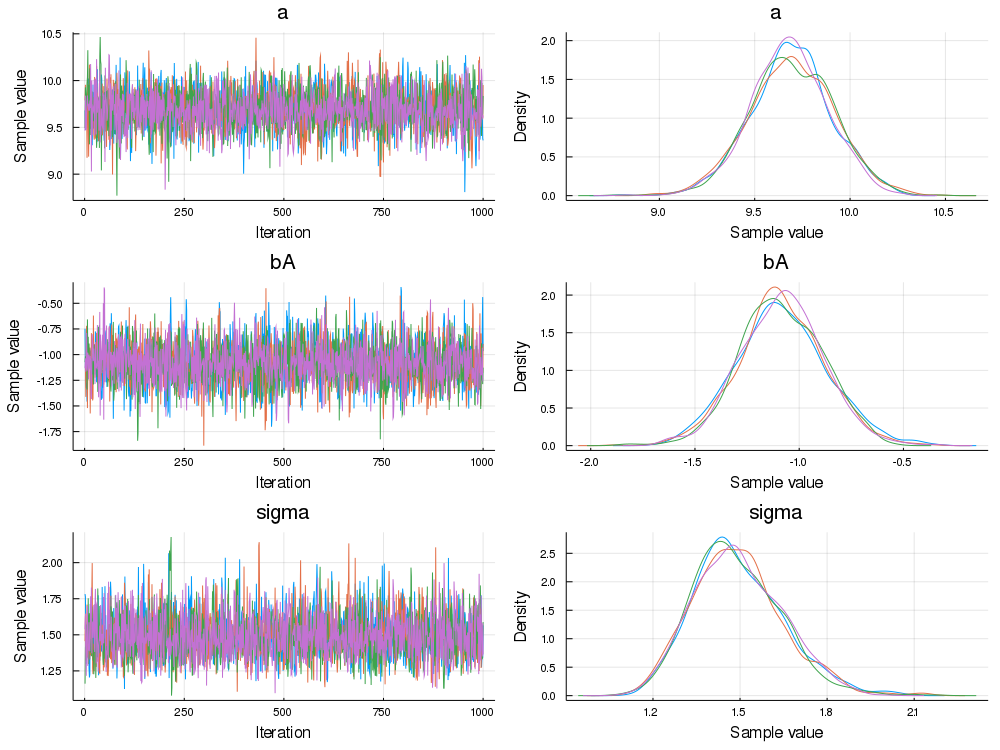

In [13]:
plot(chns)

end of m4.5d.jl#-
*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*